<img src='./lol-logo.png'></img>
<center>
    <h1>How to win in League of Legends</h1>
    <h3, style='color:gray'>or, which gameplay factors influence a player's winrate?</h4>
    <h5 >...an investigation by Adam Perry</h3>
</center>

## Introduction

---

### The Game

League of Legends is a competitive multiplayer online battle arena (MOBA) style game made by Riot Games Inc. in which 2 teams of 5 players are tasked with destroying the enemy nexus, a structure located on either end of the field of play (the map).

Though the ultimate objective is to destroy the structures that protect the nexus, players can slay other players in fights, allowing them to control the map while the enemies wait for their characters to respawn. Map control allows teams to collect gold, used to buy character-enhancing items, and capture objectives, some of which give gold and special powers, which make their characters more powerful.

Players can pick from a pool of over 150 characters, called *champions*, each with different tools at their disposal and with their own styles of play. These champions are usually played in positions of the map, known as *lanes* (where teams fight in singles or pairs), best suited for their capabilities.

### The Goal

A player's greatest interest is to maximize the amount of games they win, since wins are representative of the skill of a player. Though winning seems straightforward (defeat the enemy nexus), the factors which contribute to a win are complexly intertwined: there are several factors which contribute to the ebb and flow of power for each team, and thus are important for the teams to think about when trying to win.

So, for this project, I want to see which factor contributes the most to wins and would therefore be the most important factor for teams to focus upon such that they can maximize their win potential.

### The Data

Players have access to the [Riot API](https://developer.riotgames.com/), a server that responds to queries with information about players, their match history, and their gameplay statistics for each match. Query headers specify players and matches to be queried and their subsequent responses are encoded as JSON objects.

Before making requests, players must generate an API key that is valid for 24 hours and provides authentication for accessing the data. This can be done by logging in and going to their Riot API dashboard.

### The Terminology

Here are some terms that are important to know for interpreting the data:

**Summoner**
* The player themselves, their ingame name being their "summoner name".

**Champion**
* The character played by the player with unique abilities and playstyle potential.

**Winrate**
* The proportion of wins to games played for a player.

**Ranked; Unranked**
* Gamemodes which the player can select before matching with other players in teams.
* Ranked games are matches that contribute to a player's matchmaking rating (using Riot's proprietary algorithm) which represents the skill of a player. Players are matched with other players within a threshold relative to their matchmaking rating.
* Unranked games are matches that don't contribute to a player's matchmaking rating.

**Kills; Assists; Deaths**
* Kills are the amount of enemies slain, such that they were delivered the finishing blow, by a player.
* Assists are the amount of enemies slain by a player's team that a player contributed to, but did not deliver the finishing blow to.
* Deaths are the amount of times a player was slain and put on a respawn timer, the interval of time they must wait before playing again in the same match.

**Kill-Death-Assist Ratio (KDA)**
* The proportions of kills and assists to deaths.

**Kill Participation (KP%)**
* The proportion of kills and assists to the overall kills of a team.

**Creep Score**
* The amount of NPC monsters on the enemy team slain by a player, each of which gives the player gold.

**Wards**
* Items which can be placed on the map by a player that grant vision of the map at that point that is only revealed if a team player or structure is nearby.

**Vision Score**
* A score representing the amount of vision control (by either placing a team ward or destroying an enemy ward) a player has contributed to on the map.

### The "Golden" Rule

In general, the winrate of a player will trend towards 50% such that they win and lose half of their games.

When a winrate reaches 50%, it usually indicates that a player is accurately rated at their appropriate skill level, since they win and lose at the same rate as other players in their skill group.

So, for the purpose of this project, any statistic that corresponds to a 50% winrate should be considered irrelevant, since it does not contribute to winning. Any statistic that is related to an above-50% winrate should be considered to contribute towards maximizing winrate; conversely, any statistic related to a sub-50% winrate should be considered to contribute towards minimizing winrate.

## Setting Up

---

### i. Importing

To fetch the data from the Riot API, we will need the `requests` module and the `time` module for querying data and catching errors.

We will be using `Pandas` for organizing the data and both `Matplotlib` and `Seaborn` for visualizing the data.

The `datetime` and `IPython` imports are used to process the data and control cell output.

The module `operator` lets us use the `itemgetter` function to sort our dicts by value.

We'll also need to use the `train_test_split` function from `sklearn` to test the accuracy of the model we will eventually create using `OLS` and `LogisticRegression`.

In [1149]:
from datetime import datetime as dt
from datetime import timedelta as td
from matplotlib import pyplot as plt
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from scipy.stats import f_oneway
import matplotlib.style as style
import pandas as pd
import seaborn as sns
import numpy as np
import operator
import requests
import time

style.use('fivethirtyeight')

### ii. Constants

Here, I define the specific source of my data.

`USER` and `REGION` are the username and the region of the player whose data I am collecting.

`API_KEY` is the key required to query the Riot API. Any League of Legends player can generate an API key online, but it expires after 24 hours.

`TIMEZONE` is the timezone to which the dates of each match will be converted.

In [645]:
USER = 'pandemic 2020'
REGION = 'na1'
API_KEY = 'RGAPI-368c0a91-05ab-41ff-ab65-e1ae9f294fc7'
TIMEZONE = 'US/Eastern'

### iii. Defining important functions

In order to fetch, organize, and process data from the Riot API on the internet into our Pandas dataframes in memory, I have defined the following functions to make this process easier:

`api_request(query, headers)`

* Gets the data at URL `query` with specified `headers`.
* A wrapper for the `requests.get` function that catches errors and handles timeouts.
* Since the Riot API only allows a handful of requests at a time, this function waits until the timeout threshold is passed so that all the data can be collected.

`get_player_id(player_name)`

* Gets the ID of a player by their username.
* The Riot API requires a player's ID to query their match history.

`get_match(match_id)`

* Gets all of the information about a specific match based on its ID.
* This includes all of the statistics for each team and every player.

`build_match_list(player_name, num_games)`

* Constructs a list of all the matches played by a player up to `num_games`.
* If the value `-1` is passed into `num_games`, this function returns the entire match history of a player.

`build_match_table(match_list)`

* Compiles all of the information associated with each match in `match_list` into a list.
* This process takes time depending on how many matches are being retrieved. One match is retrieved every second, but requests will have to wait for 30 seconds after each retrieval of 100 matches.
* To show the process of these queries, the index of the current match being retrieved is displayed in the cell output. Comparing this value to the amount of games being retrieved allows one to predict how much time is left until this process is done.

`get_stats_list(player_name, match_table, match_id_list)`

* Gets the statistics associated with a specific player for the matches in `match_id_list` from `match_table`.
* This is necessary since `match_table` contains statistics for every player, not just the one specified by `USER`.

In [665]:
def api_request(query, headers):
    attempt = 0
    while(True):
        r = requests.get(query, headers=headers)
        if(attempt >= 100):
            raise Exception('Request timed out: ' + str(r.status_code))
        elif(r.status_code in (401, 403)):
            raise Exception('Authentication error.')
        elif(r.status_code >= 400):
            time.sleep(3)
            attempt += 1
        else:
            return r

def get_player_id(player_name):
    r = api_request(
        'https://' + REGION + '.api.riotgames.com/lol/summoner/v4/summoners/by-name/' + player_name,
        headers={'X-Riot-Token': API_KEY}
    )
    return r.json()['accountId']

def get_match(match_id):
    r = api_request(
        'https://' + REGION + '.api.riotgames.com/lol/match/v4/matches/' + str(match_id),
        headers={'X-Riot-Token': API_KEY}
    )
    return r.json()

def build_match_list(player_name, num_games):
    player_id = get_player_id(player_name)
    match_list = list()
    index = 0
    
    if(num_games == -1):
        while(True):
            r = api_request(
                'https://' + REGION + '.api.riotgames.com/lol/match/v4/matchlists/by-account/' + player_id
                + '?beginIndex=' + str(index),
                headers={'X-Riot-Token': API_KEY}
                )
            if(not r.json()['matches']):
                return match_list
            match_list.append(r.json()['matches'])
        if(r.status_code >= 400):
            time.sleep(3)
        index += 100
            
    while((num_games - index) > 100):
        r = api_request(
            'https://' + REGION + '.api.riotgames.com/lol/match/v4/matchlists/by-account/' + player_id
            + '?beginIndex=' + str(index),
            headers={'X-Riot-Token': API_KEY}
           )
        match_list.append(r.json()['matches'])
        index += 100
    
    r = api_request(
        'https://' + REGION + '.api.riotgames.com/lol/match/v4/matchlists/by-account/' + player_id
        + '?endIndex=' + str(num_games) + '&beginIndex=' + str(index),
        headers={'X-Riot-Token': API_KEY}
    )
    match_list.append(r.json()['matches'])
    
    return match_list

def build_match_table(match_list):
    match_table = dict()
    
    u = 1
    for match_id in match_list:
        clear_output(wait=True)
        print(u)
        match_table[str(match_id)] = get_match(match_id)
        u += 1
        
    return match_table

def get_stats_list(player_name, match_table, match_id_list):
    stat_list = dict()
    
    for match_id in match_id_list:
        participant_id = 0
        participant_stats = 0
        
        # find participant id
        for x in match_table[match_id]['participantIdentities']:
            if(x['player']['summonerName'] == USER):
                participant_id = x['participantId']
                
        # find participant stats
        for x in match_table[match_id]['participants']:
            if(x['participantId'] == participant_id):
                participant_stats = x['stats']
                participant_stats['map_side'] = 'R' if x['teamId'] == 100 else 'B'
                participant_stats['spell1Id'] = x['spell1Id']
                participant_stats['spell2Id'] = x['spell2Id']
                        
        stat_list[match_id] = participant_stats
    
    return stat_list

## Collecting the data

---

Let's start by constructing the match list for the last 300 games played by our `USER`.

In [652]:
raw_match_list = build_match_list(USER, 300)

Since this list is a JSON object (i.e. a long dict of dicts), we can't convert it into a fully tabulated DataFrame just yet.

In order to do this, we must process each element of the match list into a row and add these rows to our DataFrame.

In [660]:
match_list = pd.DataFrame()

for match in raw_match_list[:]:
    match_list = match_list.append(pd.DataFrame(match))

match_list.head()

,platformId,gameId,champion,queue,season,timestamp,role,lane
0,NA1,3497753191,131,420,13,1595013537365,SOLO,MID
1,NA1,3497700733,67,420,13,1595011539995,DUO_CARRY,BOTTOM
2,NA1,3497667399,9,420,13,1595009700078,DUO_SUPPORT,NONE
3,NA1,3497673781,131,420,13,1595007340102,SOLO,MID
4,NA1,3496449331,20,420,13,1594897177494,DUO_SUPPORT,MID


This data looks pretty nice, except for some unnecessary columns and unreadable timestamps (since it's in UNIX epoch form).

Let's start by reindexing the table based on each unique `gameId`. Then, we'll convert each timestamp into a datetime object and remove the columns we don't need.

In [661]:
match_list['gameId'] = match_list['gameId'].apply(lambda x: str(x))
match_list = match_list.set_index('gameId')

match_list['timestamp'] = match_list['timestamp'].apply(lambda x: int(str(x)))
match_list['date'] = pd.to_datetime(match_list['timestamp'], unit='ms')
match_list['date'] = match_list['date'].dt.tz_localize(tz='GMT')
match_list['date'] = match_list['date'].dt.tz_convert(tz=TIMEZONE)

match_list.pop('timestamp')
match_list.pop('role')
match_list.pop('platformId')

match_list.head()

,champion,queue,season,lane,date
gameId,,,,,
3497753191,131,420,13,MID,2020-07-17 15:18:57.365000-04:00
3497700733,67,420,13,BOTTOM,2020-07-17 14:45:39.995000-04:00
3497667399,9,420,13,NONE,2020-07-17 14:15:00.078000-04:00
3497673781,131,420,13,MID,2020-07-17 13:35:40.102000-04:00
3496449331,20,420,13,MID,2020-07-16 06:59:37.494000-04:00


We also see that the champions are not displayed by name, but instead of an integer key.

To convert these values into names, we must use a JSON object provided by Riot which has champion information and their associated keys.

I'll create a dict which indexes champion names by key, then I'll use this dict to convert each key in the champion column into its respective name.

In [662]:
r = requests.get('http://ddragon.leagueoflegends.com/cdn/10.14.1/data/en_US/champion.json')

champ_ids = dict()

for champ in r.json()['data']:
    champ_ids[r.json()['data'][champ]['key']] = champ
    
match_list['champion'] = match_list['champion'].apply(lambda x: champ_ids[str(x)])

match_list.head()

,champion,queue,season,lane,date
gameId,,,,,
3497753191,Diana,420,13,MID,2020-07-17 15:18:57.365000-04:00
3497700733,Vayne,420,13,BOTTOM,2020-07-17 14:45:39.995000-04:00
3497667399,Fiddlesticks,420,13,NONE,2020-07-17 14:15:00.078000-04:00
3497673781,Diana,420,13,MID,2020-07-17 13:35:40.102000-04:00
3496449331,Nunu,420,13,MID,2020-07-16 06:59:37.494000-04:00


Now, we must collect the statistics for each of the matches in the table we've just constructed above.

Since there are 300 matches, this process should take about `1*100 + 30*3 = 100 + 90 = 190` seconds, or about 3 minutes, based on the speed at which the functions query the data.

In [663]:
match_table = build_match_table(match_list.index)

300


Now let's collect all of the individual stats for our `USER` into the match list.

In [ ]:
stats_list = get_stats_list(USER, match_table, match_list.index)

for index,row in match_list.iterrows():
    if(stats_list[index] == 0):
        continue
    for stat_type in stats_list[index]:
        match_list.at[index, stat_type] = stats_list[index][stat_type]

At this point, we've got both the match data and the statistics associated with each of the latest 300 games our `USER` has played!

Now, we can move onto processing the data more specifically for our analysis.


## Processing the data

---

Let's start by culling the null entries of our data. Null fields occur when the API doesn't give us match information because of timeouts or request errors we can't anticipate.

I'll print the length of our original match list as well as the new length after the null matches have been removed.

In [668]:
old_len = len(match_list)
match_list = match_list[match_list['participantId'].notna()]
new_len = len(match_list)

print(old_len, '-->', new_len)

300 --> 190


One of the first things we should do is convert the boolean value of the `win` column into a 1 or 0, so that we can plug these values straight into our plots.

Also, there are some statistics that the Riot API doesn't calculate for us, such as creep score (the amount of NPC monsters slain by the player for gold), KDA (kill-death-assist ratio), and KP (kill participation, or the ratio of kills a player contributed to the team as a whole). So, we'll have to calculate these values ourselves.

In [669]:
match_list['win'] = match_list['win'].apply(lambda x: 1 if x else 0)

match_list['creep_score'] = match_list['totalMinionsKilled'] + match_list['neutralMinionsKilled']

match_list['kda'] = (match_list['kills'] + match_list['assists']) / match_list['deaths']

for index,row in match_list.iterrows():
    if(row['kda'] == np.inf):
        match_list.loc[index, 'kda'] = row['kills'] + row['assists']

Kill participation is a little more difficult to calculate, since the API also does not calculate the total amount of kills accumulated by a team. So, we will use the function below to sum the kills of each player associated with a team.

In [670]:
def get_team_kills(match_id, side, match_table):
    team_kills = 0
    
    if (side == 'R'):
        id_range = np.arange(0, 5, 1)
    else:
        id_range = np.arange(5, 10, 1)
    
    for x in id_range:
        team_kills += match_table[match_id]['participants'][x]['stats']['kills']
    
    return team_kills

Then, we'll apply this function to each row of the DataFrame.

Notice here that I must iterate through the rows individually: this is because very rarely, a team will have 0 kills, so dividing by zero will throw an error that must be catched.

In [671]:
for index,row in match_list.iterrows():
    try:
        match_list.at[index, 'kp'] = (row['kills'] + row['assists']) / get_team_kills(index, row['map_side'], match_table)    
    except ZeroDivisionError:
        match_list.at[index, 'kp'] = 0

The last step we need to accomplish before our exploration is splitting the data in testing and training sets.

We do this so we can create a model based off of our conclusions for the training set and predict its accuracy using the test set.

In [703]:
match_list_train, match_list_test = train_test_split(match_list, test_size=0.25)

match_list_train.head()

,champion,queue,season,lane,date,participantId,win,item0,item1,item2,...,perkSubStyle,statPerk0,statPerk1,statPerk2,map_side,spell1Id,spell2Id,creep_score,kda,kp
gameId,,,,,,,,,,,,,,,,,,,,,
3380549731,Cassiopeia,420,13,MID,2020-04-17 16:46:05.228000-04:00,4.0,0,3151.0,3040.0,3116.0,...,8100.0,5008.0,5008.0,5002.0,R,14.0,4.0,166.0,1.363636,0.500000
3496449331,Nunu,420,13,MID,2020-07-16 06:59:37.494000-04:00,2.0,0,1033.0,3111.0,3152.0,...,8200.0,5008.0,5008.0,5002.0,R,14.0,4.0,69.0,0.857143,0.631579
3478670061,Cassiopeia,420,13,MID,2020-06-30 11:54:40.014000-04:00,1.0,1,3089.0,3070.0,3802.0,...,8100.0,5007.0,5008.0,5003.0,R,1.0,4.0,208.0,4.000000,0.400000
3382270809,Lulu,420,13,BOTTOM,2020-04-18 16:39:50.386000-04:00,10.0,1,3853.0,3174.0,2055.0,...,8400.0,5005.0,5008.0,5002.0,B,7.0,4.0,29.0,3.571429,0.757576
3380584741,Cassiopeia,420,13,MID,2020-04-17 16:13:54.735000-04:00,5.0,1,2421.0,3040.0,3089.0,...,8100.0,5008.0,5008.0,5002.0,R,14.0,4.0,154.0,3.250000,0.406250


## Exploring and visualizing the data

---

At this point we have all of the data organized and formatted properly for us to explore.

Since the goal of this project is find out which factor maximizes winrate, we'll have to look at each of the factors that we suspect to influence this value for our player given the matches we've sampled.

Based on the 100+ statistics we can look at, let's try investigating further a couple of ideas that come to mind.

### i. Map side

This is a classic factor used in game balancing, and one that I will use to demonstrate how the golden rule indicates a meaningless statistic.

To make sense of this, we must first understand how League's map looks:

<img src='./map.jpg'></img>

Imagine a diagonal line split from top-left to bottom-right: this demarcates the sides of the map, with the blue side being in the bottom-left and the red side in the top-right.

One of the (if not the most) important factors in designing this map is making sure that it is completely balanced on both sides. This is because teams are assigned to either side of the map randomly; so, it is important that wins should be contingent on player/team performance rather than a random assignment out of their control.

To prove that either side is balanced, let's use the simple code below to calculate the winrate of our player on red and blue side:

In [1076]:
red_side_wr = match_list[match_list['map_side'] == 'R']['win'].mean()
blue_side_wr = match_list[match_list['map_side'] == 'B']['win'].mean()

print('red WR =', red_side_wr, '=', round(red_side_wr, 3), \
      '\nblue WR =', blue_side_wr, '=', round(blue_side_wr, 3))

red WR = 0.504950495049505 = 0.505 
blue WR = 0.5056179775280899 = 0.506


#### Conclusion

As we predicted, our player wins and loses approximately 50% of their games on either side.

So, as follows by the golden rule, the influence of map side on winrate is almost nil.

### ii. Time of day

_Is there a meaningful relationship between time of day and player winrate?_

We can answer this question using the date associated with each match and the average winrate associated with the matches played in a given hour.

Converting match times into hours of the day is easy, since this value is contained in the `hour` attribute of our date column's `datetime` objects.

So, we'll perform a `pd.DataFrame.groupby` and plot the results.

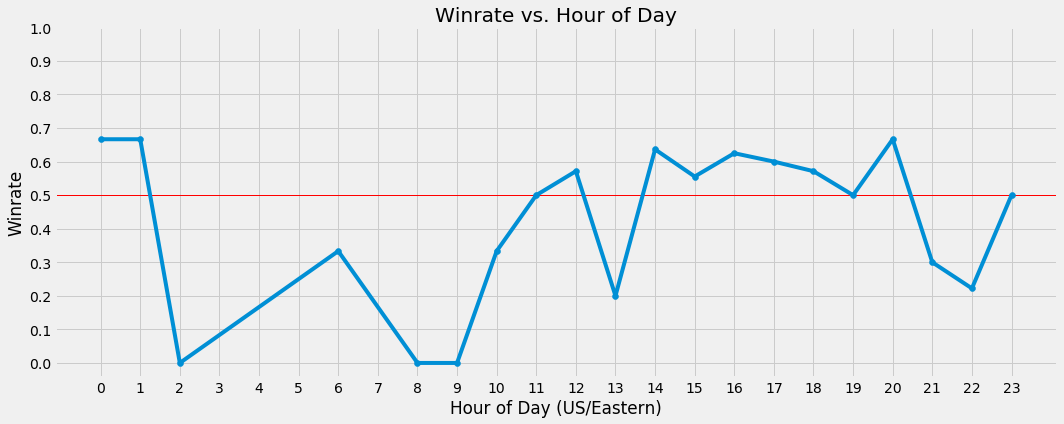

In [1094]:
by_hour = match_list_train.groupby(match_list['date'].dt.hour)

fig,ax = plt.subplots(figsize=(16,6))

ax.scatter(by_hour.mean().index, by_hour.mean()['win'])
ax.plot(by_hour.mean().index, by_hour.mean()['win'])
ax.yaxis.get_gridlines()[5].set_color('r')

ax.set_title('Winrate vs. Hour of Day')
ax.set_ylabel('Winrate')
ax.set_xlabel('Hour of Day (' + TIMEZONE + ')')

ax.set_xticks(np.arange(0, 24, 1))
ax.set_yticks(np.arange(0.0, 1.1, 0.1))

print()

It's difficult to interpret this graph without knowing how many matches are played in each of the hours, since there seems to be extrema at 2, 8, and 9 AM in which our player has a 0% winrate: we can intuit that this player probably doesn't play many games in that time since they're probably sleeping, so it would be misleading to conclude that our player always loses their games at those times.

We also want to make sure that this data is meaningful according to the golden rule.

So, let's add a line that represents the number of games played at each hour, distinguishing by ranked and unranked games.

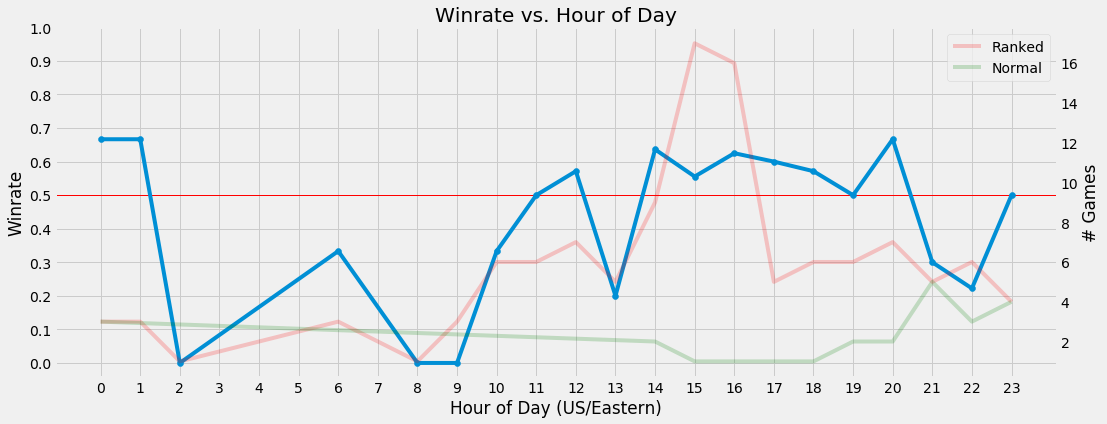

In [1095]:
by_hour_ranked = match_list_train[match_list_train['queue'] == 420].groupby(match_list['date'].dt.hour)
by_hour_other = match_list_train[match_list_train['queue'] != 420].groupby(match_list['date'].dt.hour)

ax2 = ax.twinx()
ax2.grid(False)

ax2.plot(by_hour_ranked.count().index, by_hour_ranked.count()['champion'], c='red', alpha=0.2, label='Ranked')
ax2.plot(by_hour_other.count().index, by_hour_other.count()['champion'], c='green', alpha=0.2, label='Normal')
ax2.set_ylabel('# Games')

ax2.legend()

fig

It would appear that time of day is actually influential toward player winrate, since there is not a direct relationship between games played per hour and tendency toward a 50% winrate.

As one might expect, our player plays most of their games in their awake period, which seems to be between 10 AM and 10 PM.

Since the data can be very sparse in the hours outside of this time period, we can only really interpret the data during the time where the data is richest, so the conclusions below will be about the period between 10 AM and 10 PM, where at least 5 games are sampled.

* The player loses most often at the beginning and the end of the day, with a sub-50 winrate from 10 to 11 AM and from 9 to 10 PM.
* The player peaks in winrate at 2 PM, 4 PM, and 8 PM.
* The player gradually increases in winrate from 3 to 7 PM. After 8 PM, the player will sharply to drop in winrate and remain sub-50.


#### Conclusion

This exploration gives us an interesting, qualitative conclusion: our player should warm-up between 10 AM and 12 PM, play one game at 2 PM, play carefully from 4 PM to 6 PM, then play their last games at 8 PM.

However, we shouldn't use this statistic in a general model, since the intervals are very inconsistent in number of games played.

### iii. Champion picks

---

_Do their champion picks influence our player's winrate?_

To answer this question, let's first determine which champions our player plays the most by counting the amount of games they play for each champion they have played in the last 300 games.

Text(0, 0.5, '# Games')

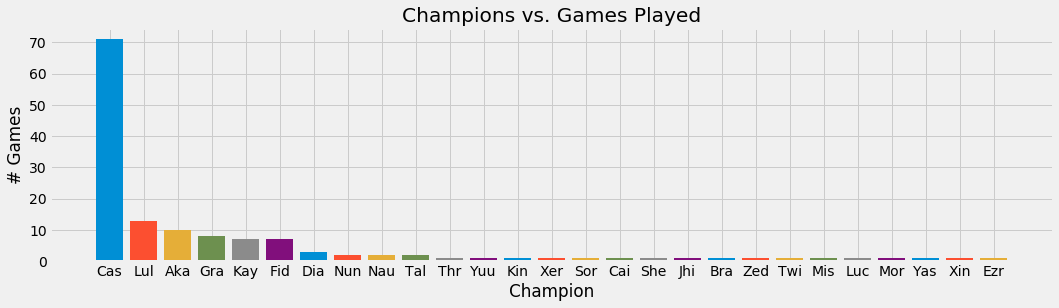

In [1100]:
games_per_champ = dict()

for champ in match_list_train[match_list_train['champion'].notna()]['champion'].unique():
    games = match_list_train[match_list_train['champion'] == champ]['champion'].count()
    games_per_champ[champ] = games

games_per_champ = sorted(games_per_champ.items(), key=operator.itemgetter(1), reverse=True)

fig,ax = plt.subplots(figsize=(16,4))
for champ,games in games_per_champ:
    ax.bar(champ[:3], games)
    
ax.set_title('Champions vs. Games Played')
ax.set_xlabel('Champion')
ax.set_ylabel('# Games')

For this player, it seems that they pick from a pool of 6 champions (Cassiopeia, Lulu, Akali, Graves, Kayn, and Fiddlesticks) for most of their games, with their most played champion being Cassiopeia.

So, since they have the most match data from our training set, let's focus our analysis on these 6 champions in particular.

In [796]:
mains = ['Cassiopeia', 'Lulu', 'Akali', 'Graves', 'Kayn', 'Fiddlesticks']

To determine the relationship between champion pick and winrate, all we need to do is look at the winrates per main:

In [840]:
pick_vs_wr = pd.DataFrame(index={'winrate'})

for champ in mains:
    pick_vs_wr[champ] = match_list_train[match_list_train['champion'] == champ]['win'].mean()
    
pick_vs_wr = pick_vs_wr.T.sort_values('winrate', ascending=False)

for champ in mains:
    pick_vs_wr.loc[champ, 'num_games'] = dict(games_per_champ)[champ]
    
pick_vs_wr

,winrate,num_games
Kayn,0.714286,7.0
Fiddlesticks,0.571429,7.0
Lulu,0.538462,13.0
Cassiopeia,0.535211,71.0
Graves,0.500000,8.0
Akali,0.300000,10.0


So, it would appear that Kayn is the champion our player should pick, since they have the highest winrate when playing that champion.

However, if we look at these champions' winrates versus their number of games played, we notice that there seems to be a relationship between these two values trending towards 50%. According to the golden rule, this would make the statistic not meaningful.

To make sure there really is a correlation, let's plot games played versus a value that represents the winrate normalized as the difference between winrate and 50% per champion.

Text(0, 0.5, 'Difference in Winrate')

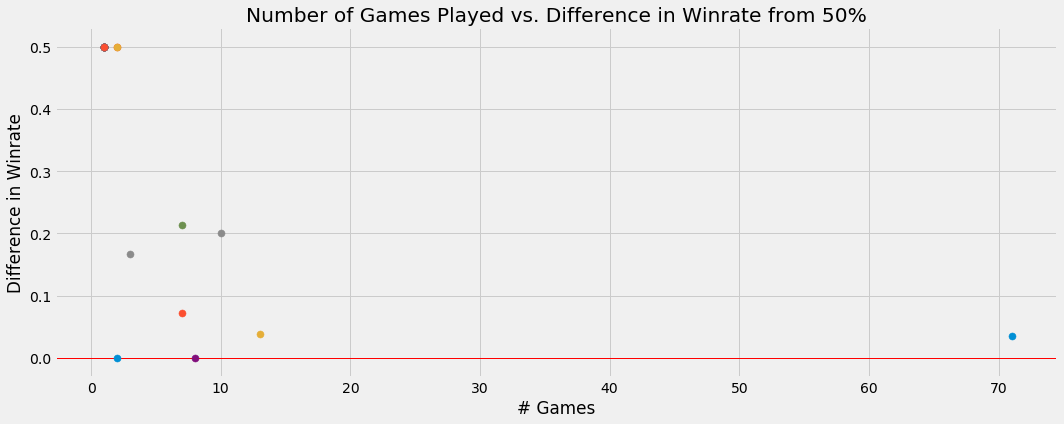

In [1103]:
fig,ax = plt.subplots(figsize=(16,6))

for champ in match_list_train['champion'].unique():
    champ_slice = match_list_train[match_list_train['champion'] == champ]
    x,y = champ_slice['champion'].count(), champ_slice['win'].mean()
    y = abs(y-0.5)
    ax.scatter(x, y, label=champ, s=50)
    
ax.set_yticks(np.arange(0,0.6,0.1))
ax.yaxis.get_gridlines()[0].set_color('r')
ax.set_title('Number of Games Played vs. Difference in Winrate from 50%')
ax.set_xlabel('# Games')
ax.set_ylabel('Difference in Winrate')

#### Conclusion

According to the graph, the games played on a champion tends toward a 50% winrate; so, as follows from the golden rule, it would appear that there this statistic will not help us maximize winrate.

### iv. Gameplay statistics

Finally, let's try looking at a few gameplay statistics that are usually assumed to be influential toward winning a game: KDA, KP%, a player's total damage dealt to champions, and a player's vision score.

First, we'll plot the value of each statistic per match over time, colored by whether or not the player's team won. Green indicates a win, and red indicates a loss.

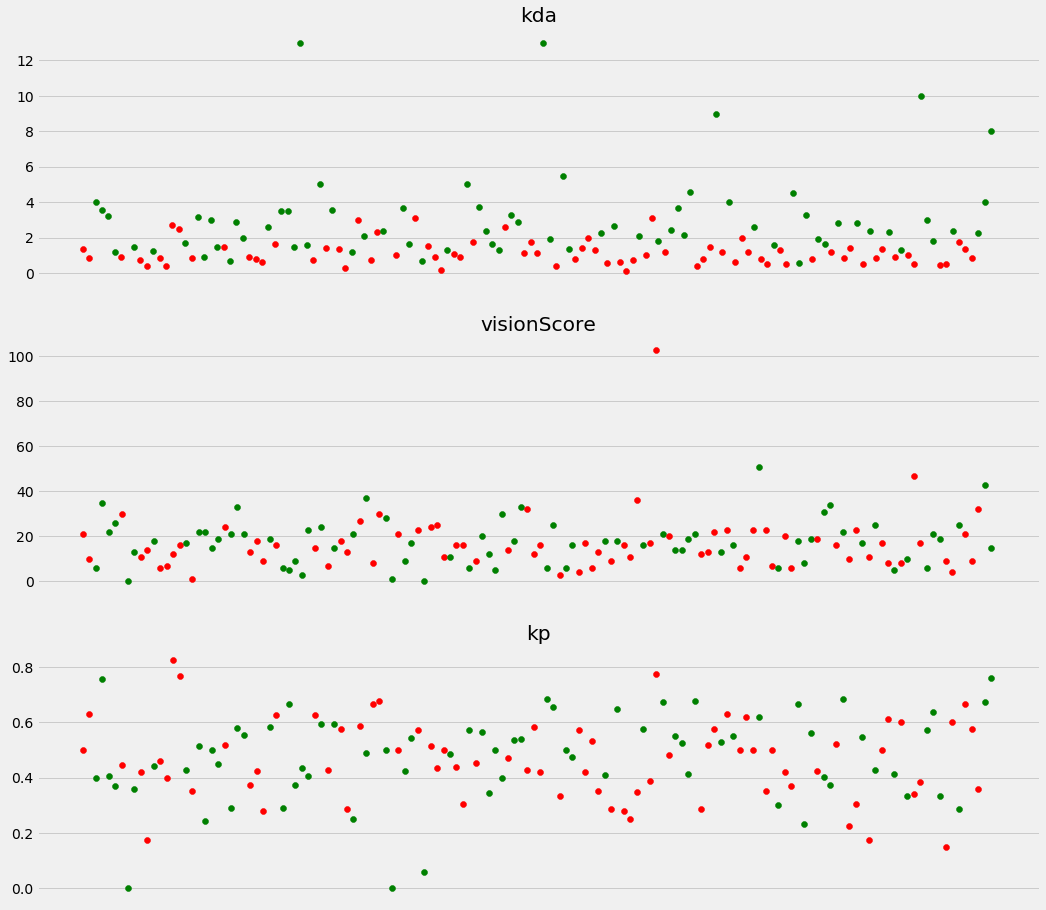

In [1079]:
n=3
fig,axs = plt.subplots(n,1, figsize=(16,5*n))
stats = {'kda', 'kp', 'visionScore'}

for index,row in match_list_train.iterrows():
    u=0
    for stat in stats:
        axs[u].scatter(index, row[stat], c=('r' if row['win'] == 0 else 'g'))
        axs[u].set_title(stat)
        u += 1

for ax in axs:
    ax.set_xticklabels([])
    ax.xaxis.grid(False)

print()

At first glance, it looks like there isn't much correlation between these values and winning more games, except for the KDA scatterplot which shows a greater distribution of wins for KDA's above around 2.

Let's see the exact distribution of each statistic, colored by win/loss.

In [1080]:
won_games = match_list_train[match_list_train['win'] == 1]
lost_games = match_list_train[match_list_train['win'] == 0]

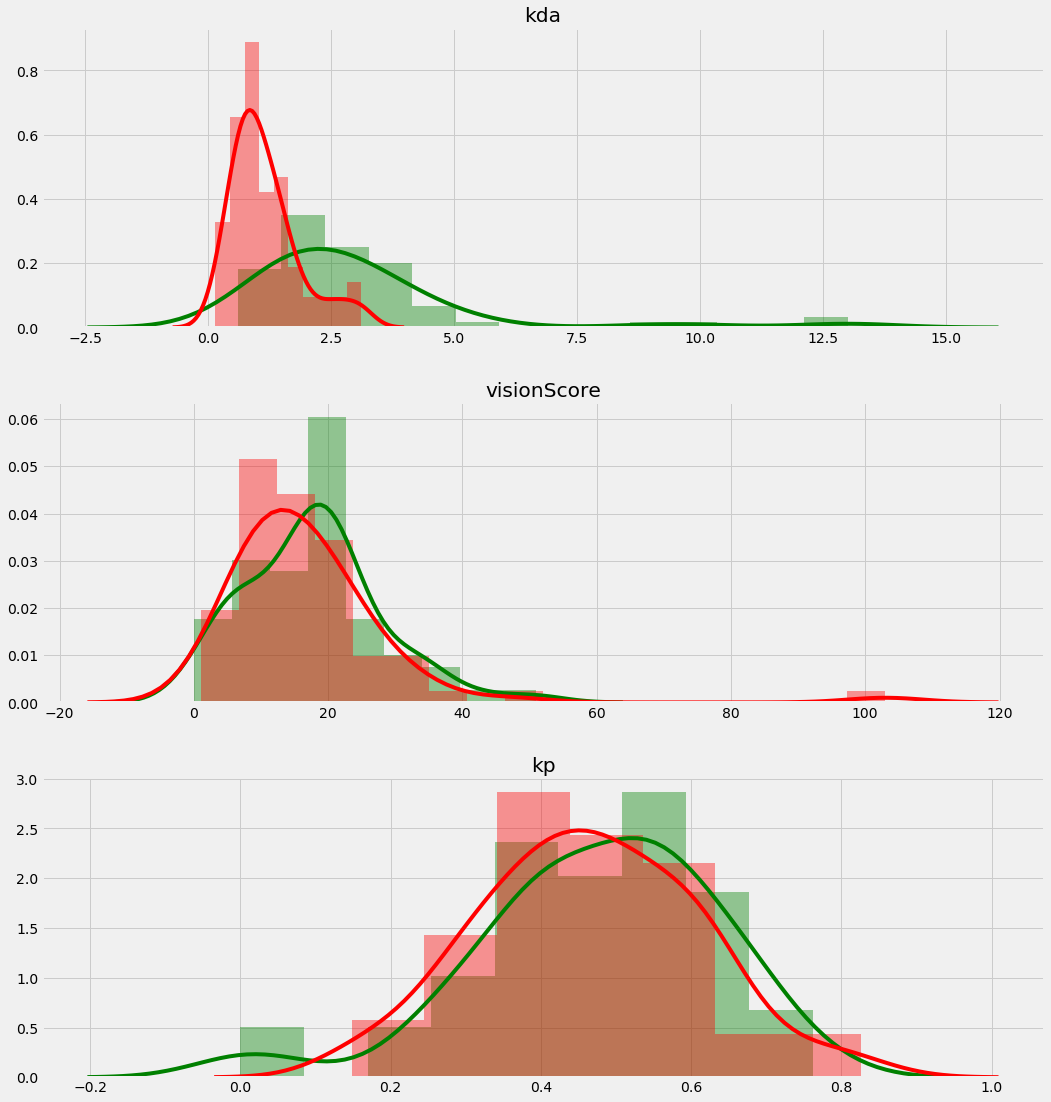

In [1081]:
fig,axs = plt.subplots(n,1, figsize=(16,6*n))
plt.subplots_adjust(hspace=0.25)

u = 0
for stat in stats:
    sns.distplot(won_games[stat], ax=axs[u], color='g')
    sns.distplot(lost_games[stat], ax=axs[u], color='r')
    axs[u].set_title(stat)
    axs[u].set_xlabel(None)
    u += 1

It would appear that, out of these statistics, KDA is the most influential towards winrate: this is because won games are normally distributed over a high KDA, while lost games are heavily distributed over a lower KDA.

For the other statistics, higher is still better: won games are generally distributed over a higher vision score and KP% compared to lower values in lost games.

#### Conclusion

Since each of these three statistics has the relationship of higher value to higher winrate in our training data, we should use them as the key statistis for a win-predicting model. However, we should be careful of KP% and vision score because their distribution suggests a minimal influence on winrate, i.e. perhaps contributing to overfitting in our model.

## Making the model

---

Based on our conclusions from the above distributions, we want to decide between a single feature-regression and a multiple-feature regression.

### Single-feature regression

Let's start with fitting a model that predicts wins based on just KDA:

In [1228]:
x_train = match_list_train.dropna()['kda'].values.reshape(-1, 1)
y_train = match_list_train.dropna()['win'].values

lin_reg = sm.OLS(y_train,x_train).fit()
print(lin_reg.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.576
Model:                            OLS   Adj. R-squared (uncentered):              0.572
Method:                 Least Squares   F-statistic:                              165.5
Date:                Sat, 18 Jul 2020   Prob (F-statistic):                    1.87e-24
Time:                        23:43:48   Log-Likelihood:                         -76.641
No. Observations:                 123   AIC:                                      155.3
Df Residuals:                     122   BIC:                                      158.1
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

The model itself has a Prob(F) of approximately zero, indicating that our model is sufficient to reject the null hypothesis.

The parameter for KDA has a p-value of 0, indicating KDA is statistically significant.

### Multiple-feature regression

Next, let's fit a model that predicts wins based on KDA, KP%, and vision score:

In [1211]:
X_train = match_list_train.dropna()[['kda', 'kp', 'visionScore']].values

log_reg = sm.OLS(y_train,X_train).fit()
print(log_reg.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.598
Model:                            OLS   Adj. R-squared (uncentered):              0.588
Method:                 Least Squares   F-statistic:                              59.53
Date:                Sat, 18 Jul 2020   Prob (F-statistic):                    1.20e-23
Time:                        23:41:08   Log-Likelihood:                         -73.285
No. Observations:                 123   AIC:                                      152.6
Df Residuals:                     120   BIC:                                      161.0
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

This model has an insignificantly higher Prob(F) than the single-feature model since they are both approximately zero, indicating that this model allows us to reject the null hypothesis.

Also, the R-squared is 0.598, which indicates that this model is better at fitting the data than the single-feature model (that has an R-squared of 0.576).

However, if we look at the p-values for x2 (KP%) and x3 (vision score), we find them to be greater than 0.05 and thus insignificant. Therefore, this multiple regression model will likely suffer from overfitting and therefore accuracy.

#### Conclusion

Let's use the single-feature model for evaluation, since it looks less dubious than the multiple-feature regression.

## Evaluating the model

---

Let's run an F-test using our model on the test data and see how accurate it is at predicting winrate by first comparing our observed data with our predictions.

In [1311]:
f_oneway(y_test, lin_reg.predict(x_test))

F_onewayResult(statistic=0.07268909508469933, pvalue=0.7881382584139099)

The results of this test are pretty surprising--it claims that our model has a confidence interval below 25%, which indicates a very inaccurate fit.

Since the report on our model using the training data indicated statistical significance, we should investigate why the model appears inaccurate.

Let's first compare the model's behavior on the training data and the testing data:

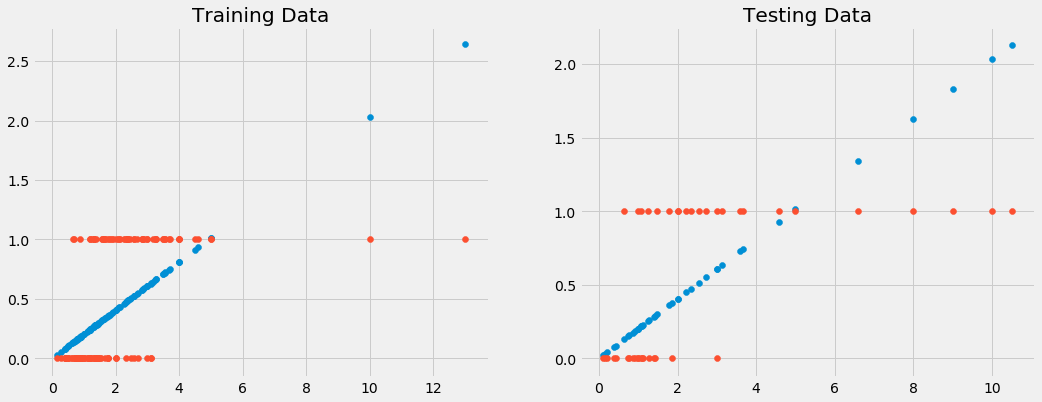

In [1283]:
x_test = match_list_test.dropna()['kda'].values.reshape(-1, 1)
y_test = match_list_test.dropna()['win'].values

y_pred = lin_reg.predict(x_test)

f_oneway(y_test, y_pred)

fig,axs = plt.subplots(1,2, figsize=(16,6))

axs[0].scatter(x_train, lin_reg.predict(x_train))
axs[0].scatter(x_train, y_train)
axs[0].set_title('Training Data')

axs[1].scatter(x_test, lin_reg.predict(x_test))
axs[1].scatter(x_test, y_test)
axs[1].set_title('Testing Data')

print()

The behavior of the regression for the training and testing data look pretty similar. But, it looks like the extrema of the model predict values above 1.0 which are impossible. But, we know the model is generating these values since it is a single-degree linear regression applied to a categorical variable with boolean values.

Let's normalize the results of the regression to get a sense of its accuracy by calculating its residuals.

To do this, we will consider any regression value of 0.5 or higher to represent a win, and any value lower to represent a loss.

In [1306]:
results = pd.DataFrame()

results['KDA'] = x_test.flatten()
results['Observed'] = y_test
results['Predicted'] = lin_reg.predict(x_test)
results['Normal'] = results['Predicted'].apply(lambda x: 1 if x>=0.5 else 0)
results['Error'] = results['Observed'].subtract(results['Normal'])

results.head()

,KDA,Observed,Predicted,Normal,Error
0,2.000000,1,0.406248,0,1
1,3.000000,0,0.609372,1,-1
2,2.538462,1,0.515623,1,0
3,8.000000,1,1.624993,1,0
4,0.200000,0,0.040625,0,0


Then, let's generate a violin plot for each statistic to compare their distributions.

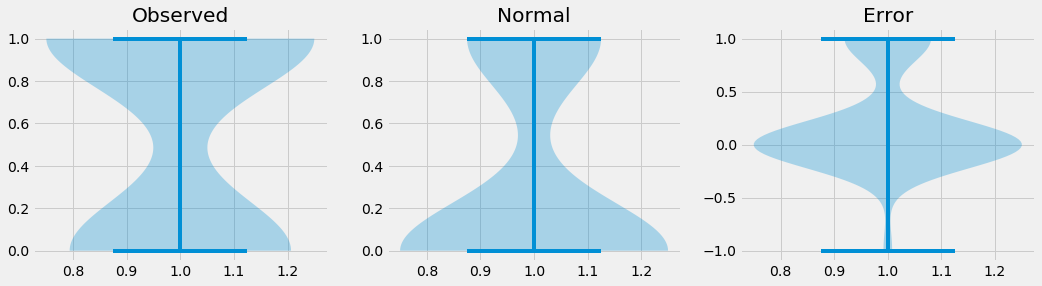

In [1309]:
fig,axs = plt.subplots(1,3,figsize=(16,4))
axs[0].violinplot(results['Observed'])
axs[1].violinplot(results['Normal'])
axs[2].violinplot(results['Error'])

axs[0].set_title('Observed')
axs[1].set_title('Normal')
axs[2].set_title('Error')

print()

After normalizing its results, the model looks very accurate: not only are the distributions similar for the observed and the normalized data, but despite some error at predicting wins, the error is almost zero for predicting losses.

Let's re-do the F-test using the normalized data.

In [1312]:
f_oneway(results['Observed'], results['Normal'])

F_onewayResult(statistic=4.006031363088059, pvalue=0.0486447730070939)

These results are very promising: the p-value is below 0.05, indicating a confidence interval of >95%, indicating our model is very accurate at predicting wins from KDA.

#### Conclusion

We've found an accurate model for predicting wins based on KDA, with a positive relationship between the two values.

Formally, the model can be represented as the following function:

$P(win) = ceil[0.2031x]$

Therefore,

$P(win) = 1 \equiv 0.50 = 0.2031x$

$\frac{0.50}{0.2031} = x $

$2.462 = x $

In other words, based on our player's data, we can conclude that a KDA of at least 2.462 will most yield a win more than 95\% of the time.

## Insights and conclusions

---

* Though we didn't look at the impact of every single statistic, we found one factor that is strikingly influential on our player's winrate: KDA.
* The error distribution of our model suggested that a lower KDA will almost always yield a loss, while a higher KDA will greatly increase the potential for a win.
* With knowledge of this model, our player can now focus on making sure they are maximizing their KDA to a value of at least 2.5 in order to win.
* With the data collection and processing methods we used, we can run another analysis of the player once they have made these changes to their gameplay, and find other factors that might begin to contribute to greater winrate as our player's skill rating changes the environment of each match and thus the playstyles required to win.